In [ ]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS135_Project_B/

/content/drive/MyDrive/CS135_Project_B


In [ ]:
!pwd

/content/drive/MyDrive/CS135_Project_B


In [ ]:
data_dir = os.path.abspath("data_fashion/")

In [ ]:
train_x = pd.read_csv(os.path.join(data_dir, "x_train.csv"))
train_y_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

valid_x = pd.read_csv(os.path.join(data_dir, "x_valid.csv"))
valid_y_df = pd.read_csv(os.path.join(data_dir, "y_valid.csv"))

In [ ]:
train_x['class_name'] = train_y_df['class_name']
duplicate_counts = {'pullover': 4, 'top': 400, 'trouser': 400}
df = pd.DataFrame()

for class_name, count in duplicate_counts.items():
    subset = train_x[train_x['class_name'] == class_name]
    duplicated_subset = pd.concat([subset] * count, ignore_index=True)
    df = pd.concat([df, duplicated_subset], ignore_index=True)

other_classes = train_x[~train_x['class_name'].isin(duplicate_counts.keys())]
df = pd.concat([df, other_classes], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['class_name'].value_counts()

sandal      800
sneaker     800
dress       400
trouser     400
pullover    400
top         400
Name: class_name, dtype: int64

In [ ]:
train_data = df
valid_x['class_name'] = valid_y_df['class_name']
valid_data = valid_x

In [ ]:
for label, df in [('train', train_data), ('valid', valid_data)]:
  print("Contents of %s_data.csv: dataframe of shape %s" % (label, str(df.shape)))

Contents of train_data.csv: dataframe of shape (3200, 785)
Contents of valid_data.csv: dataframe of shape (600, 785)


In [ ]:
category_mapping = {'dress': 0, 'pullover': 1, 'top': 2, 'trouser': 3, 'sandal': 4, 'sneaker': 5}
train_data['class_name'] = train_data['class_name'].map(category_mapping)
valid_data['class_name'] = valid_data['class_name'].map(category_mapping)

In [ ]:
train_data['class_name'].value_counts()

4    800
5    800
0    400
3    400
1    400
2    400
Name: class_name, dtype: int64

In [ ]:
valid_data['class_name'].value_counts()

0    100
3    100
4    100
2    100
1    100
5    100
Name: class_name, dtype: int64

In [ ]:
full_data = result = pd.concat([train_data, valid_data], axis=0)
full_data.shape

(3800, 785)

In [ ]:
img_rows, img_cols = 28, 28
num_classes = 6

def data_prep_train(raw):
    out_y = keras.utils.to_categorical(raw.class_name, num_classes)

    num_images = raw.shape[0]
    x_as_array = raw.values[:,:-1]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    x_shaped_array = x_shaped_array.astype('float32')
    out_x = x_shaped_array / 255.0

    return out_x, out_y

In [ ]:
x, y = data_prep_train(full_data)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
x.shape

(3800, 28, 28, 1)

In [ ]:
unique_values, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)

for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

print('-----')

unique_values, counts = np.unique(np.argmax(y_valid, axis=1), return_counts=True)

for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

Value: 0, Count: 352
Value: 1, Count: 347
Value: 2, Count: 357
Value: 3, Count: 362
Value: 4, Count: 606
Value: 5, Count: 636
-----
Value: 0, Count: 148
Value: 1, Count: 153
Value: 2, Count: 143
Value: 3, Count: 138
Value: 4, Count: 294
Value: 5, Count: 264


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=(img_rows, img_cols, 1),
                 kernel_regularizer=regularizers.l2(0.1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

In [ ]:
alphas = [1e-5, 1e-4, 0.001, 0.01, 0.1, 1]
print(alphas)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

models = []
train_balanced_accs = []
valid_balanced_accs = []

for i in alphas:

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=(img_rows, img_cols, 1),
                   kernel_regularizer=regularizers.l2(i)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu',
                   kernel_regularizer=regularizers.l2(i)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu',
                   kernel_regularizer=regularizers.l2(i)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(512, activation='relu',
                  kernel_regularizer=regularizers.l2(i)))
  model.add(Dense(num_classes, activation='softmax'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,
                metrics=['accuracy'])

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

  model.fit(x_train, y_train,
            batch_size=32,
            epochs=50,
            validation_data=(x_valid, y_valid),
            verbose=1,
            callbacks=[early_stopping])

  models.append(model)

  train_yhat_probs = model.predict(x_train)
  train_yhat_classes = np.argmax(train_yhat_probs, axis=1)
  train_balanced_acc = balanced_accuracy_score(np.argmax(y_train, axis=1), train_yhat_classes)

  valid_yhat_probs = model.predict(x_valid)
  valid_yhat_classes = np.argmax(valid_yhat_probs, axis=1)
  valid_balanced_acc = balanced_accuracy_score(np.argmax(y_valid, axis=1), valid_yhat_classes)

  print(f"alpha: {i}, train_score: {train_balanced_acc:.5f}, validation_score: {valid_balanced_acc:.5f}")
  train_balanced_accs.append(train_balanced_acc)
  valid_balanced_accs.append(valid_balanced_acc)

Epoch 1/50
84/84 [==============================] - 8s 65ms/step - loss: 0.4521 - accuracy: 0.8323 - val_loss: 0.1972 - val_accuracy: 0.9430
Epoch 2/50
84/84 [==============================] - 5s 60ms/step - loss: 0.1427 - accuracy: 0.9545 - val_loss: 0.1785 - val_accuracy: 0.9491
Epoch 3/50
84/84 [==============================] - 8s 93ms/step - loss: 0.1101 - accuracy: 0.9624 - val_loss: 0.1147 - val_accuracy: 0.9711
Epoch 4/50
84/84 [==============================] - 5s 60ms/step - loss: 0.0746 - accuracy: 0.9782 - val_loss: 0.1384 - val_accuracy: 0.9623
Epoch 5/50
84/84 [==============================] - 6s 68ms/step - loss: 0.0706 - accuracy: 0.9808 - val_loss: 0.0933 - val_accuracy: 0.9737
Epoch 6/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0533 - accuracy: 0.9850 - val_loss: 0.0918 - val_accuracy: 0.9816
Epoch 7/50
84/84 [==============================] - 5s 60ms/step - loss: 0.0432 - accuracy: 0.9906 - val_loss: 0.0951 - val_accuracy: 0.9781
Epoch 8/50
84

In [ ]:
max_index = valid_balanced_accs.index(max(valid_balanced_accs))
alpha_best = alphas[max_index]
print(alpha_best)

0.0001


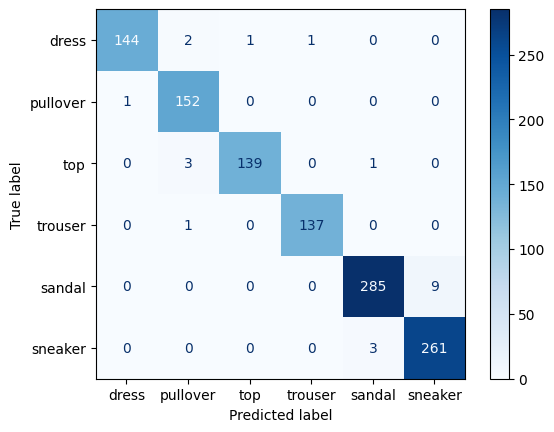

In [ ]:
model_best = models[max_index]
valid_yhat_probs = model_best.predict(x_valid, verbose=0)

valid_yhat_classes = np.argmax(valid_yhat_probs, axis=1)

class_names = ['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']
cm = confusion_matrix(np.argmax(y_valid, axis=1), valid_yhat_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

In [ ]:
test_x = pd.read_csv(os.path.join(data_dir, "x_test.csv"))

In [ ]:
img_rows, img_cols = 28, 28

def data_prep_test(raw):

    num_images = raw.shape[0]
    x_as_array = raw.values[:,:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    x_shaped_array = x_shaped_array.astype('float32')
    out_x = x_shaped_array / 255.0

    return out_x

In [ ]:
x_test = data_prep_test(test_x)

In [ ]:
test_yhat_probs = model_best.predict(x_test)
test_yhat_probs[:5]

19/19 [==============================] - 0s 15ms/step


array([[3.2770600e-05, 2.7786555e-06, 9.9996418e-01, 7.7810057e-08,
        2.3551619e-08, 1.2287065e-07],
       [2.1005537e-04, 4.6590682e-08, 4.2457745e-07, 9.9978948e-01,
        1.6272349e-08, 2.3385141e-10],
       [1.3046512e-04, 9.8944163e-01, 7.2757709e-03, 9.8531062e-05,
        3.0447603e-03, 8.9001514e-06],
       [2.1855462e-02, 1.5047680e-01, 8.2545257e-01, 9.8486023e-04,
        1.2221603e-03, 8.0478403e-06],
       [9.9895310e-01, 5.8671620e-05, 6.1178993e-04, 1.9751712e-04,
        6.0000943e-06, 1.7292192e-04]], dtype=float32)

In [ ]:
test_yhat_classes = np.argmax(test_yhat_probs, axis=1)
category_mapping = {0: 'dress', 1: 'pullover', 2: 'top', 3: 'trouser', 4: 'sandal', 5: 'sneaker'}
test_yhat = [category_mapping[class_index] for class_index in test_yhat_classes]
test_yhat[:5]

['top', 'trouser', 'pullover', 'top', 'dress']

In [ ]:
np.savetxt('Q2/yhat_test.txt', test_yhat, delimiter='\n', fmt='%s')